In [1]:
%matplotlib inline

import os
import sys

from astropy.io import fits
from matplotlib import pyplot as plt
import numpy as np
from scipy.signal import find_peaks
from scipy import interpolate

from rascal.calibrator import Calibrator
from rascal.atlas import Atlas
from rascal import util

In this example, we use a guassian function as a spectrum, and the detector configuration of GMOS (longslit central 3 chips) to explain what `effective_pixels` is.

First, we need to describe the pixel position on the detector plane.

In [2]:
# All pixel values here are unbinned
# n for north
# s for south
hamamatsu_width = 2048

# chip gaps
hamamatsu_n_gap = 67
hamamatsu_s_gap = 61

def create_pixel_array(northsouth, binning):
    '''
    The GMOS longslit spectrum spreads over three CCDs. This function creates
    the pixel list corresponding the binned pixels adjusted for the chip gaps,
    which can lead to a non-integer shift in the number of pixels.
    Parameters
    ----------
    northsout: str
        Indicate whether the Gemini north or south, because the chip gaps are
        different.
    binning : numeric
        The binning factor
    Returns
    -------
    pixels: numpy.array
        The pixel values adjusted for chip gaps for the corresponding pixel.
    '''

    binned_width = hamamatsu_width / binning

    if northsouth == 'north':
        gap_binned_width = hamamatsu_n_gap / binning
    elif northsouth == 'south':
        gap_binned_width = hamamatsu_s_gap / binning
    else:
        raise ValueError('Please choose from "north" or "south".')

    pixels = np.concatenate(
        (np.arange(binned_width),
         np.arange(binned_width + gap_binned_width,
                   binned_width * 2 + gap_binned_width),
         np.arange(binned_width * 2 + gap_binned_width * 2,
                   binned_width * 3 + gap_binned_width * 2)))

    return pixels



The fucntion `create_pixel_array()` generate the effective position of the pixels on the detector plane where the chip gaps (as a function of the number of pixels) are taken into account. By simply concatentating arrays, the chip gaps will be ignored and create a discontinuous function of pixel values which will lead to errorenous polynomial fit of the pixel-to-wavelength relation.

To get the effective pixels values of the GMOS north

In [3]:
effective_pixels = create_pixel_array('north', 1)
pixels = np.arange(len(effective_pixels)).astype('int')
rawpix_to_pix_itp = interpolate.interp1d(effective_pixels, pixels)

and use a broad gaussian function centred at 3000 as a spectrum.

Text(0, 0.5, 'arbitrary intensity')

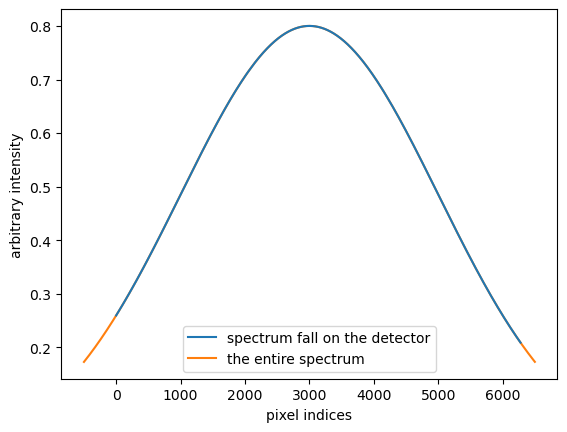

In [4]:
def gaus(x, a, b, x0, sigma):
    """
    Simple Gaussian function.
    Parameters
    ----------
    x: float or 1-d numpy array
        The data to evaluate the Gaussian over
    a: float
        the amplitude
    b: float
        the constant offset
    x0: float
        the center of the Gaussian
    sigma: float
        the width of the Gaussian
    Returns
    -------
    Array or float of same type as input (x).
    """

    return a * np.exp(-((x - x0) ** 2) / (2 * sigma**2)) + b


spectrum = gaus(effective_pixels, 0.8, 0., 3000, 2000.)

_pix = np.arange(-500, 6500)
full_spectrum = gaus(_pix, 0.8, 0., 3000, 2000.)

plt.plot(effective_pixels, spectrum, label='spectrum fall on the detector', zorder=10)
plt.plot(_pix, full_spectrum, label='the entire spectrum', zorder=5)
plt.legend()
plt.xlabel('pixel indices')
plt.ylabel('arbitrary intensity')


We can then illustrate the GMOS longslit set up where are are 3 detectors on the focal plane in the dispersion direction:

Text(0, 0.5, 'arbitrary intensity')

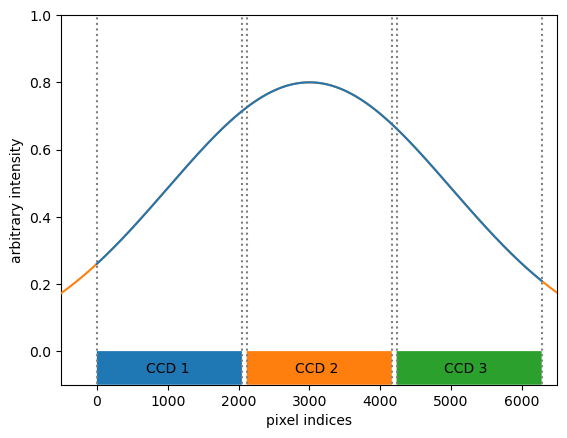

In [5]:
plt.fill_between(np.arange(0, hamamatsu_width), -0.1, 0)
plt.fill_between(np.arange(hamamatsu_width + hamamatsu_n_gap, hamamatsu_width * 2 + hamamatsu_n_gap), -0.1, 0)
plt.fill_between(np.arange(hamamatsu_width * 2 + hamamatsu_n_gap * 2, hamamatsu_width * 3 + hamamatsu_n_gap * 2), -0.1, 0)

plt.vlines(0, -1, 1, ls=":", color='grey')
plt.vlines(hamamatsu_width, -1, 1, ls=":", color='grey')
plt.vlines(hamamatsu_width + hamamatsu_n_gap, -1, 1, ls=":", color='grey')
plt.vlines(hamamatsu_width * 2 + hamamatsu_n_gap, -1, 1, ls=":", color='grey')
plt.vlines(hamamatsu_width * 2 + hamamatsu_n_gap * 2, -1, 1, ls=":", color='grey')
plt.vlines(hamamatsu_width * 3 + hamamatsu_n_gap * 2, -1, 1, ls=":", color='grey')

plt.text(700, -0.065, "CCD 1")
plt.text(2800, -0.065, "CCD 2")
plt.text(4900, -0.065, "CCD 3")

plt.plot(effective_pixels, spectrum, zorder=10)
plt.plot(_pix, full_spectrum, zorder=5)
plt.ylim(-0.1, 1.0)
plt.xlim(min(_pix), max(_pix))

plt.xlabel('pixel indices')
plt.ylabel('arbitrary intensity')

In order to perform wavelength calibration properly, we need to include the physical separation between the CCDs in the unit of number of pixels. So that the list/array of effective pixels contains two discontinued steps that are necessary to map the pixels to the spectrum properly. Another advantage of such implementation is that this can handle sub-pixel physical sepeartions.

The following shows the mapping of effetive pixel to pixel.

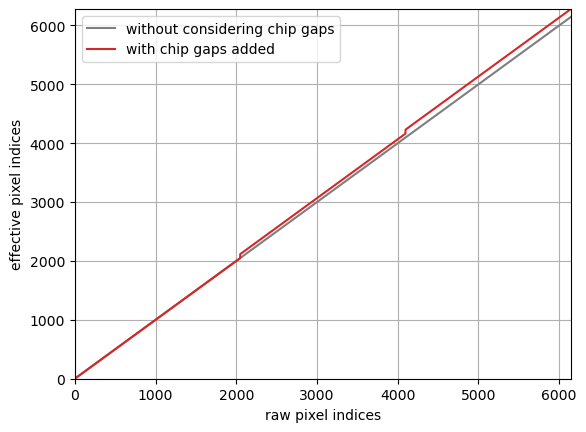

In [6]:
plt.plot(pixels, pixels, color='C7', label="without considering chip gaps")
plt.plot(pixels, effective_pixels, color='C3', label="with chip gaps added")
plt.legend()
plt.xlabel('raw pixel indices')
plt.ylabel('effective pixel indices')
plt.xlim(0, max(pixels))
plt.ylim(0, max(effective_pixels))
plt.grid()

Here we illustrate how the "computer sees" the spectrum with and without the effective pixels:

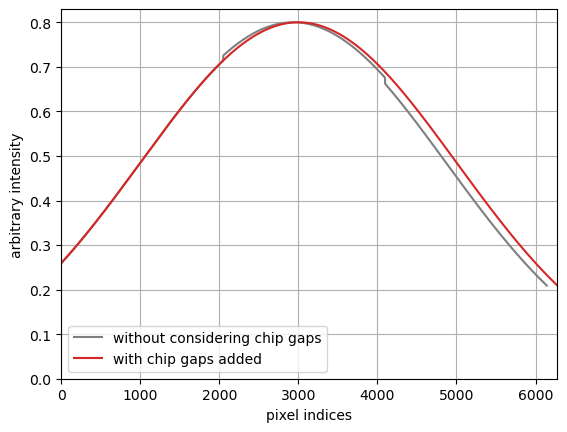

In [7]:
plt.plot(pixels, spectrum, color='C7', label="without considering chip gaps")
plt.plot(effective_pixels, spectrum, color='C3', label="with chip gaps added")
plt.legend()
plt.xlabel('pixel indices')
plt.ylabel('arbitrary intensity')
plt.xlim(0, max(effective_pixels))
plt.ylim(ymin=0)
plt.grid()

If we apply this to an arc spectrum, the pixel-to-wavelength are still correctly mapping to each other in the figure. However, when we fit for a polynomial function, we would be correlating a continuous function (arc wavelengths) to a discontinuous function (pixel indices without taking into account of the chip gaps). That, at best, leads to biased wavelength solution near the chip gaps.